Using device: cpu
Epoch 1/10, Loss: 0.1926
Epoch 2/10, Loss: 0.0717
Epoch 3/10, Loss: 0.0522
Epoch 4/10, Loss: 0.0451
Epoch 5/10, Loss: 0.0353
Epoch 6/10, Loss: 0.0314
Epoch 7/10, Loss: 0.0275
Epoch 8/10, Loss: 0.0242
Epoch 9/10, Loss: 0.0231
Epoch 10/10, Loss: 0.0187


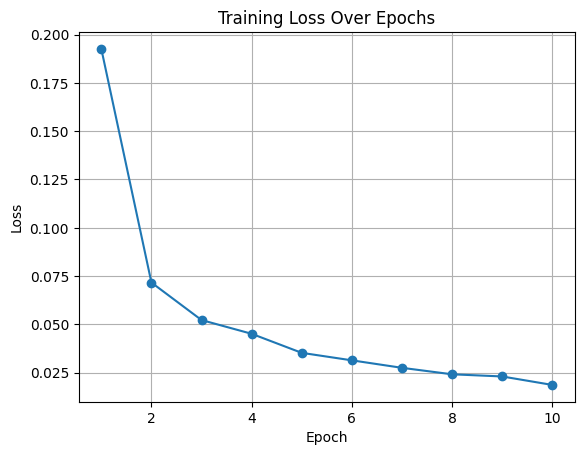


Test Accuracy: 99.25%

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       0.99      1.00      1.00      1135
           2       0.99      0.99      0.99      1032
           3       1.00      0.99      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.99      0.99       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.99      1.00      0.99       974
           9       0.99      0.99      0.99      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



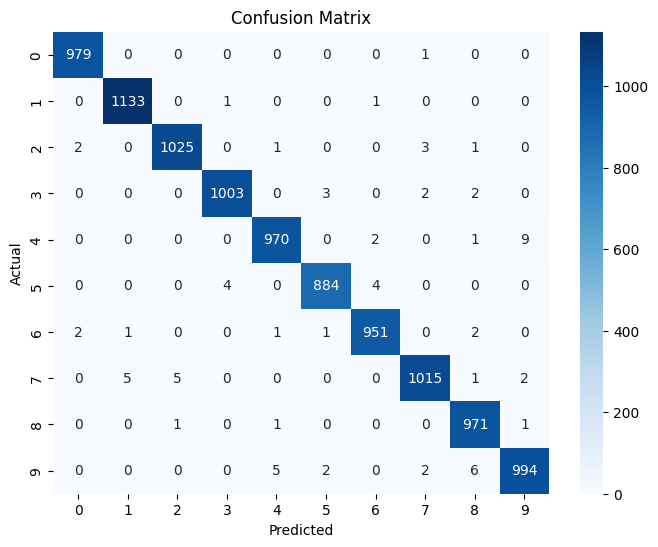

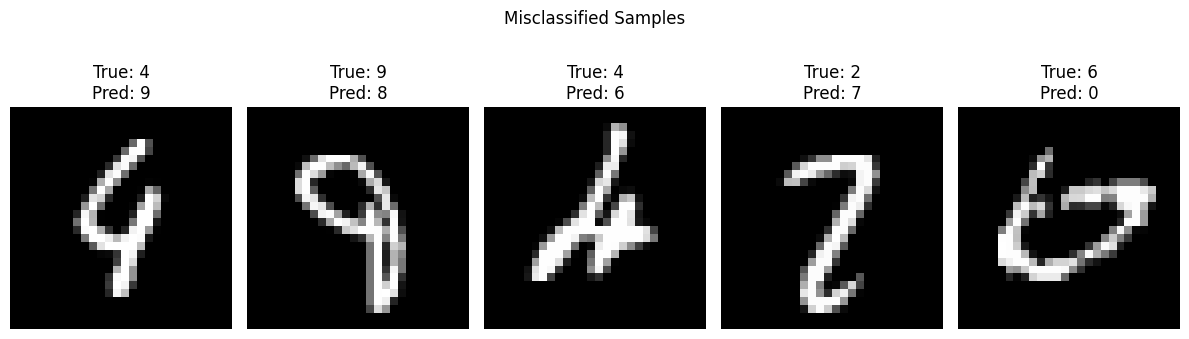

Model saved as mnist_cnn_model.pth


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

# 1. Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 2. Data loading and preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_data, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_data, batch_size=1000, shuffle=False, num_workers=2)

# 3. Define CNN Model
class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Fixed input size after pooling
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))    # (N, 32, 14, 14)
        x = self.pool(F.relu(self.conv2(x)))    # (N, 64, 7, 7)
        x = torch.flatten(x, 1)                 # Flatten to (N, 64*7*7)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        return self.fc2(x)

model = CNNModel().to(device)

# 4. Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 5. Training
epochs = 10
train_losses = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

# 6. Plot training loss
plt.plot(range(1, epochs+1), train_losses, marker='o')
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

# 7. Evaluation
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        y_true.extend(labels.numpy())
        y_pred.extend(preds)

# Accuracy
accuracy = np.mean(np.array(y_true) == np.array(y_pred))
print(f"\nTest Accuracy: {accuracy * 100:.2f}%")

# 8. Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

# 9. Confusion Matrix
conf = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# 10. Misclassified images
misclassified_indices = [i for i, (t, p) in enumerate(zip(y_true, y_pred)) if t != p]

plt.figure(figsize=(12, 4))
for i in range(5):
    idx = misclassified_indices[i]
    img, _ = test_data[idx]
    plt.subplot(1, 5, i+1)
    plt.imshow(img.squeeze(), cmap='gray')
    plt.title(f"True: {y_true[idx]}\nPred: {y_pred[idx]}")
    plt.axis('off')
plt.suptitle("Misclassified Samples")
plt.tight_layout()
plt.show()

# 11. Save the model
torch.save(model.state_dict(), "mnist_cnn_model.pth")
print("Model saved as mnist_cnn_model.pth")
